Took code from Week 1.8 Project and axle data. helper and solution file are included here, but I did not clean out the unnecessary code. bivariate plotting function included here but other aspects (marginal, copula) are still included in `helper.py`. `solution.py` is not needed, but the model definition code uses a dictionary that is set up there. 

Not sure why the figure in this notebook is not rendered with transparent background, but the svg is transparent, so i ignored it.

`pyvinecopulib` was added to virtual env using pip without any issue. not included in requirements file to avoid build issues on the server.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from helper import plot_contour
from helper import Bivariate
from solution import *

from matplotlib import rcParams
rcParams.update({'font.size': 16})
# TUDelft colors palette
colors = ["#0C2340","#00B8C8","#0076C2","#6F1D77","#EF60A3","#A50034","#E03C31","#EC6842","#FFB81C","#6CC24A","#009B77"]

In [2]:
X1 = univariate_RV_dict("Heaviest axle", "$AX_{max}$", "kN")
X2 = univariate_RV_dict("Lightest Axle", "$AX_{min}$", "kN")
X1["data"], X2["data"] = np.genfromtxt('./data_axle.csv',
                                       delimiter=",", unpack = True)

print(f'Length of the dataset: {X1["data"].size}')
print(f'Mean and standard deviation:',
      f'({X1["data"].mean():.3f}, {X1["data"].std():.3f}).')
print(f'Mean and standard deviation:',
      f'({X2["data"].mean():.3f}, {X2["data"].std():.3f}).')

Length of the dataset: 992
Mean and standard deviation: (38.216, 10.020).
Mean and standard deviation: (55.941, 18.914).


In [3]:
dist_parameters = st.lognorm.fit(X1["data"], floc = 0)
dist_object = st.lognorm(*dist_parameters)
X1["LN"] = univariate_model_dict("Lognormal",
                                 dist_parameters, dist_object)

dist_parameters = st.gumbel_r.fit(X1["data"])
dist_object = st.gumbel_r(*dist_parameters)
X1["Gum"] = univariate_model_dict("Gumbel (right)",
                                 dist_parameters, dist_object)

dist_parameters = st.lognorm.fit(X2["data"], floc = 0)
dist_object = st.lognorm(*dist_parameters)
X2["LN"] = univariate_model_dict("Lognormal",
                                 dist_parameters, dist_object)

dist_parameters = st.gumbel_r.fit(X2["data"])
dist_object = st.gumbel_r(*dist_parameters)
X2["Gum"] = univariate_model_dict("Gumbel (right)",
                                 dist_parameters, dist_object)

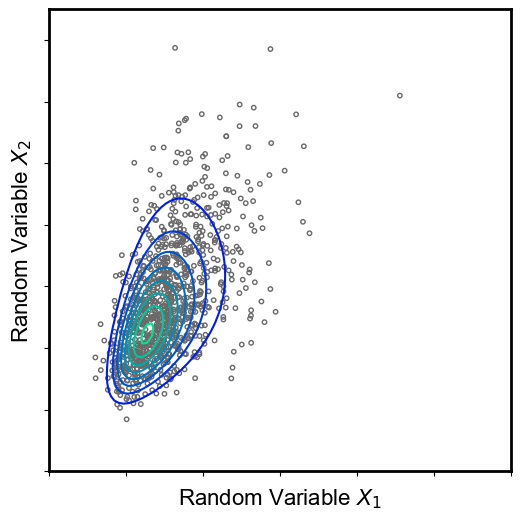

In [4]:
# -----------------------------------------------------------------
plot_title                  = ""
font                        = "Arial"
x_label                     = "Random Variable $X_1$"
y_label                     = "Random Variable $X_2$"
legend                      = False
grid                        = False
save_svg                    = True
remove_ticks                = False
remove_ticks_labels         = True
file_name                   = "../book/figures/cover_bi"
# -----------------------------------------------------------------

M2 = bivariate_model_dict("Model 2", "Gum", X1, "Gum", X2, 0.54)

M = M2

rvs_temp = M["X1X2"].rvs(1000).T

import matplotlib.cm as cm
def plot_contour(bivar, xy_lim, data=None,
                 design_case=None, design_region=None,
                 nb_points=100):
    
    f = plt.figure(figsize=(6,6))
    ax = f.add_subplot() # axes_class=AxesZero)
    plt.setp(ax.spines.values(), linewidth=2)

    xlim = [xy_lim[0], xy_lim[1]]
    ylim = [xy_lim[2], xy_lim[3]]

    x = np.linspace(xlim[0], xlim[1], nb_points)
    y = np.linspace(ylim[0], ylim[1], nb_points)
    X,Y = np.meshgrid(x,y)
    pdf = np.zeros(X.shape)
    for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                # if X[i,j]>0 and Y[i,j]>0:
                pdf[i,j] = bivar.pdf([X[i,j], Y[i,j]])
    
    ax.contour(X, Y, pdf, levels=8, cmap=cm.winter)
    
    if isinstance(data, np.ndarray):
        ax.scatter(data[0,:], data[1,:], s=10.0,
                   facecolors='none', edgecolors='dimgray',
                   label='Data')
    
    if isinstance(design_region, np.ndarray):
        ax.plot(design_region[0,:], design_region[1,:],
                label='Design Boundary', color='k')
        ax.fill_between(design_region[0,:], design_region[1,:],
                        ylim[1], label='Design Region', color='grey')
    
    if design_case:
        ax.plot(design_case[0], design_case[1], 'ro',
                label='Design Case')
    
    ax.set_aspect("equal")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # ax.set_xlabel(r"$X_1$", fontsize=14)
    # ax.set_ylabel(r"$X_2$", fontsize=14)
    if isinstance(design_region, np.ndarray) or design_case:
        ax.legend()
    return f, ax 

fig, ax = plot_contour(M["X1X2"], [0, 150, 0, 150],
                       data=rvs_temp, nb_points=100)

ax.set_xlabel(x_label, fontfamily=font)
ax.set_ylabel(y_label, fontfamily=font)

fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

if grid: ax.grid()
if legend: ax.legend(prop={"family":font})
if remove_ticks: ax.set_xticks([]); ax.set_yticks([])
if remove_ticks_labels: ax.set_xticklabels([]); ax.set_yticklabels([])
if save_svg: plt.savefig(file_name + '.svg', bbox_inches=0, transparent=True)

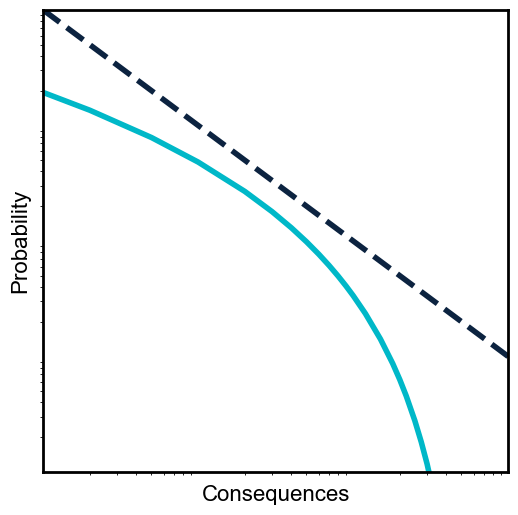

In [5]:
# -----------------------------------------------------------------
plot_title                  = ""
font                        = "Arial"
x_label                     = "Consequences"
y_label                     = "Probability"
legend                      = False
grid                        = False
save_svg                    = True
remove_ticks                = True
remove_ticks_labels         = True
file_name                   = "../book/figures/cover_fn"
# -----------------------------------------------------------------

fig2 = plt.figure(figsize=(6,6))
ax2 = fig2.add_subplot() # axes_class=AxesZero)
ax2.set_title(plot_title, fontfamily=font)


plt.setp(ax2.spines.values(), linewidth=2)

right = 500
top = .5e-5

u = np.array([1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 220, 250, 275, 300, 350, 400, 450, 475])
v = 1e-8 + top*(np.log(right) - np.log(u))**3/np.log(right)


C = 10**-3
alpha = 1

limit_line_N = np.array([1, 1000])
limit_line_P = C/limit_line_N**alpha

# Visualize

# plotting
# ax2.plot(limit_line_N, limit_line_P, '--', label='Limit Line', color=colors[0], linewidth=4)
ax2.plot(u, v, label='Risk Curve', color=colors[1], linewidth=4)
ax2.plot(limit_line_N, limit_line_P, '--', label='Limit Line', color=colors[0], linewidth=4)

ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.set_xlim(1, 1000)
ax2.set_ylim(10**(-7),.001)
# ax2.set_yticks([10**(-7),10**(-5),10**(-3),10**(-1)])

ax2.tick_params(axis='x', labelsize=13, width=2, length=8)
ax2.tick_params(axis='y', labelsize=13, width=2, length=8)

ax2.set_xlabel(x_label, fontfamily=font)
ax2.set_ylabel(y_label, fontfamily=font)

fig2.patch.set_alpha(0.)
ax2.patch.set_alpha(0.)

if grid: ax2.grid()
if legend: ax2.legend(prop={"family":font})
if remove_ticks: ax2.set_xticks([]); ax2.set_yticks([])
if remove_ticks_labels: ax2.set_xticklabels([]); ax2.set_yticklabels([])
if save_svg: plt.savefig(file_name + '.svg', bbox_inches=0, transparent=True)

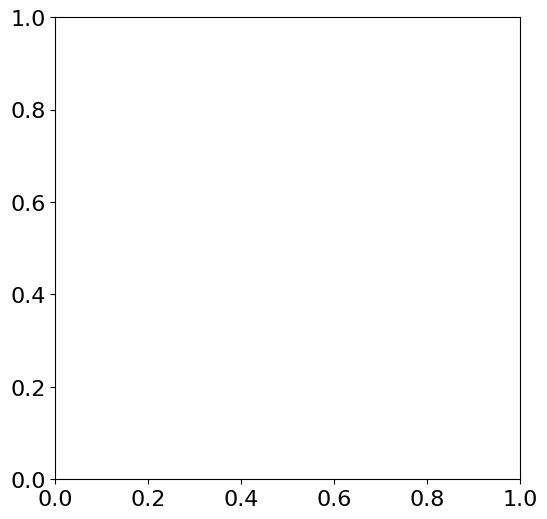

In [6]:
# combine ax and ax2 in one figure and overlay them offset to each other
fig3 = plt.figure(figsize=(6,6))
ax_bi = fig3.add_subplot() # axes_class=AxesZero)

# add 
